In [36]:
import dataset
import metrics
import evaluate

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json

obj = 'cable' # CHOOSE THE OBJECT TO BE ANALYSED

### CHANGE WITH THE PATHS OF YOUR FILES ###
tflite_model_path = 'YOUR_TFLITE_MODEL_PATH'
metrics_file_path = 'YOUR_OBJECTS_METRICS.JSON_PATH' #json file generated in main.py
dataset_root_path = 'YOUR_DATASET_ROOT_PATH'
###########################################

SEED = 45
tf.keras.utils.set_random_seed(SEED)
plt.rcParams["figure.dpi"] = 300

In [37]:
def invoke_tflite(tflite_model, img):
    """
    Invoke tflite model to predict with batch size = 1.

    Args:
        tflite_model: TfLite model.
        img: image to predict the label.

    Return:
        label: int. Predicted label.
    """
    interpreter = tf.lite.Interpreter(model_content= tflite_model)
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    input_shape = interpreter.get_input_details()[0]['shape']
    img = tf.cast(img, tf.float32)
    interpreter.resize_tensor_input(input_index, (1,) + img.shape)
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_index, np.expand_dims(img, axis=0)) # add a batch dimension
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)
    return output


def display_random_test(tflite_model_path, imgs, labels, obj, seed=45):
    """
    Plot a randomly selected image from the test set and show the predicted and actual class.

    Args:
        tflite_model_path: str indicating the tflite model path.
        imgs: NumPy array with the images.
        labels: NumPy array with the labels of the images.
        obj: str. Object name.
        seed: int. Value used to initialize the pseudo-random number generator.
    """
    label_map = {0:'Normal', 1:'Defective'}
    with open(tflite_model_path, 'rb') as f:
        tflite_model = f.read()
    rand_idx = np.random.randint(0,len(imgs))
    pred_logits = invoke_tflite(tflite_model, imgs[rand_idx])
    pred_label = int(pred_logits.argmax(axis=1)[0])
    plt.imshow(imgs[rand_idx])
    plt.title(f'Actual: {label_map[labels[rand_idx]]} - Predicted: {label_map[pred_label]}')
    plt.show()

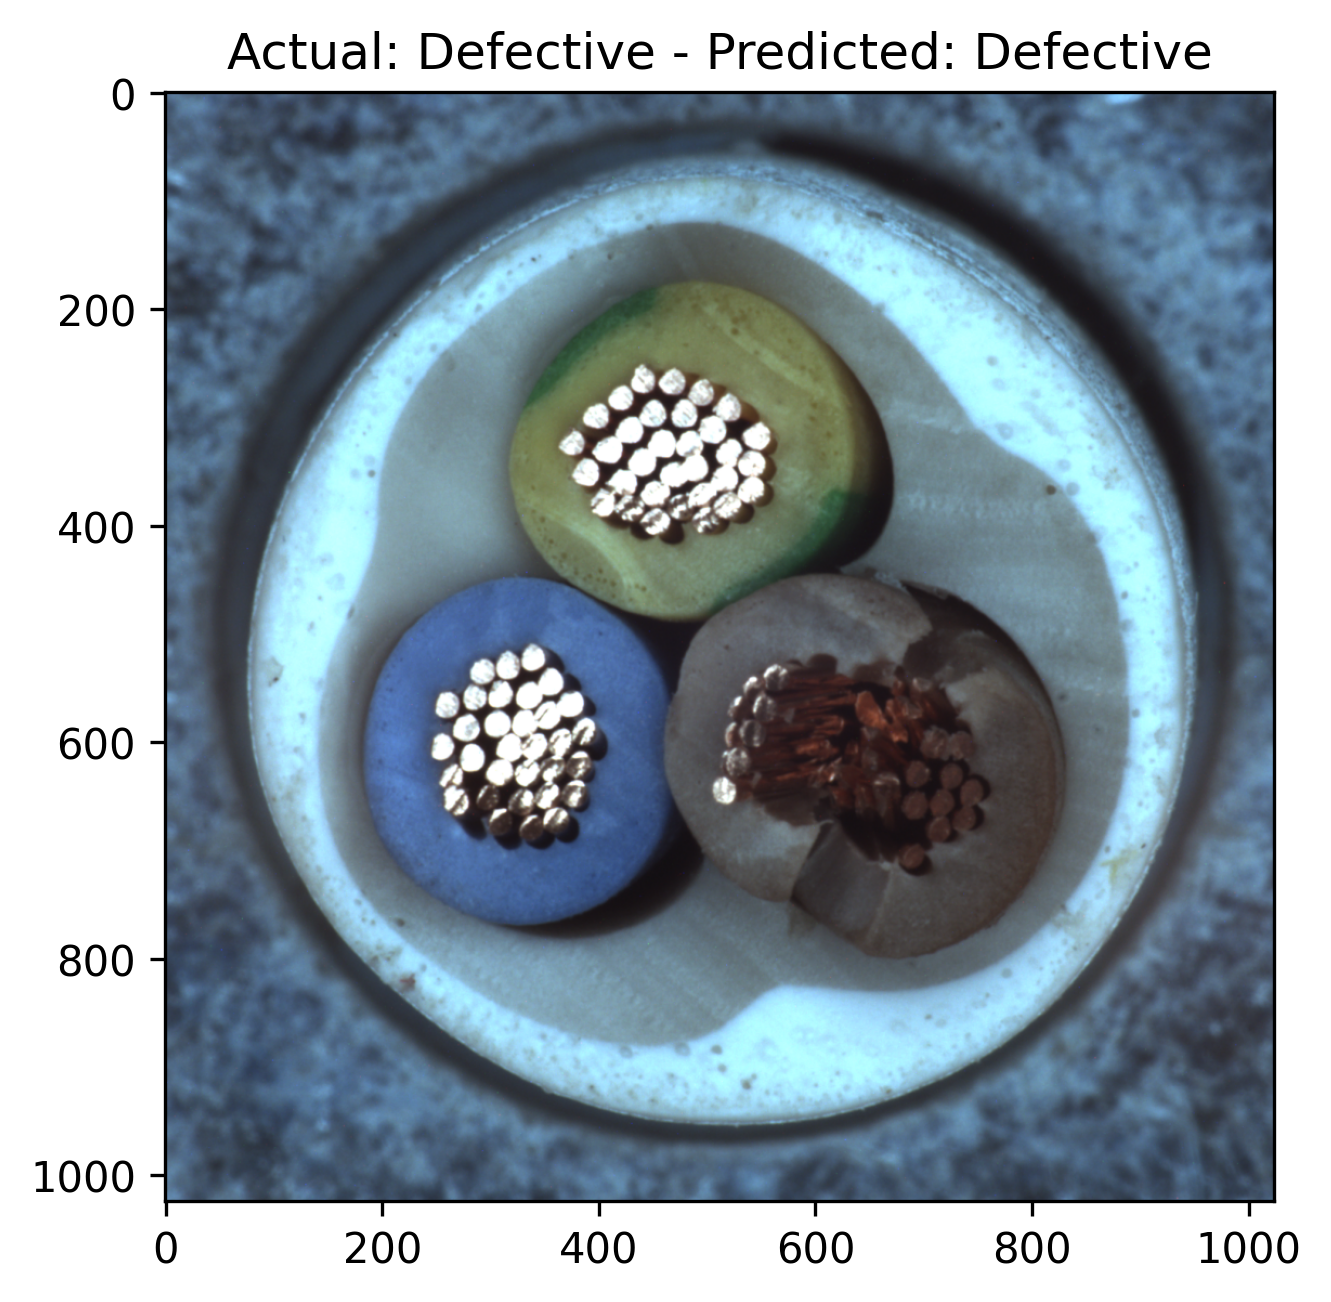

In [45]:
# RANDOMLY SELECT AN IMG AND SHOW IT WITH THE MODEL'S PREDICTION
train_data, val_data, test_data = dataset.preprocess_dataset(dataset_root_path, obj, seed=SEED)
imgs_test, labels_test = test_data
display_random_test(tflite_model_path= tflite_model_path,
                    imgs= imgs_test,
                    labels= labels_test,
                    obj= obj,
                    seed=SEED)

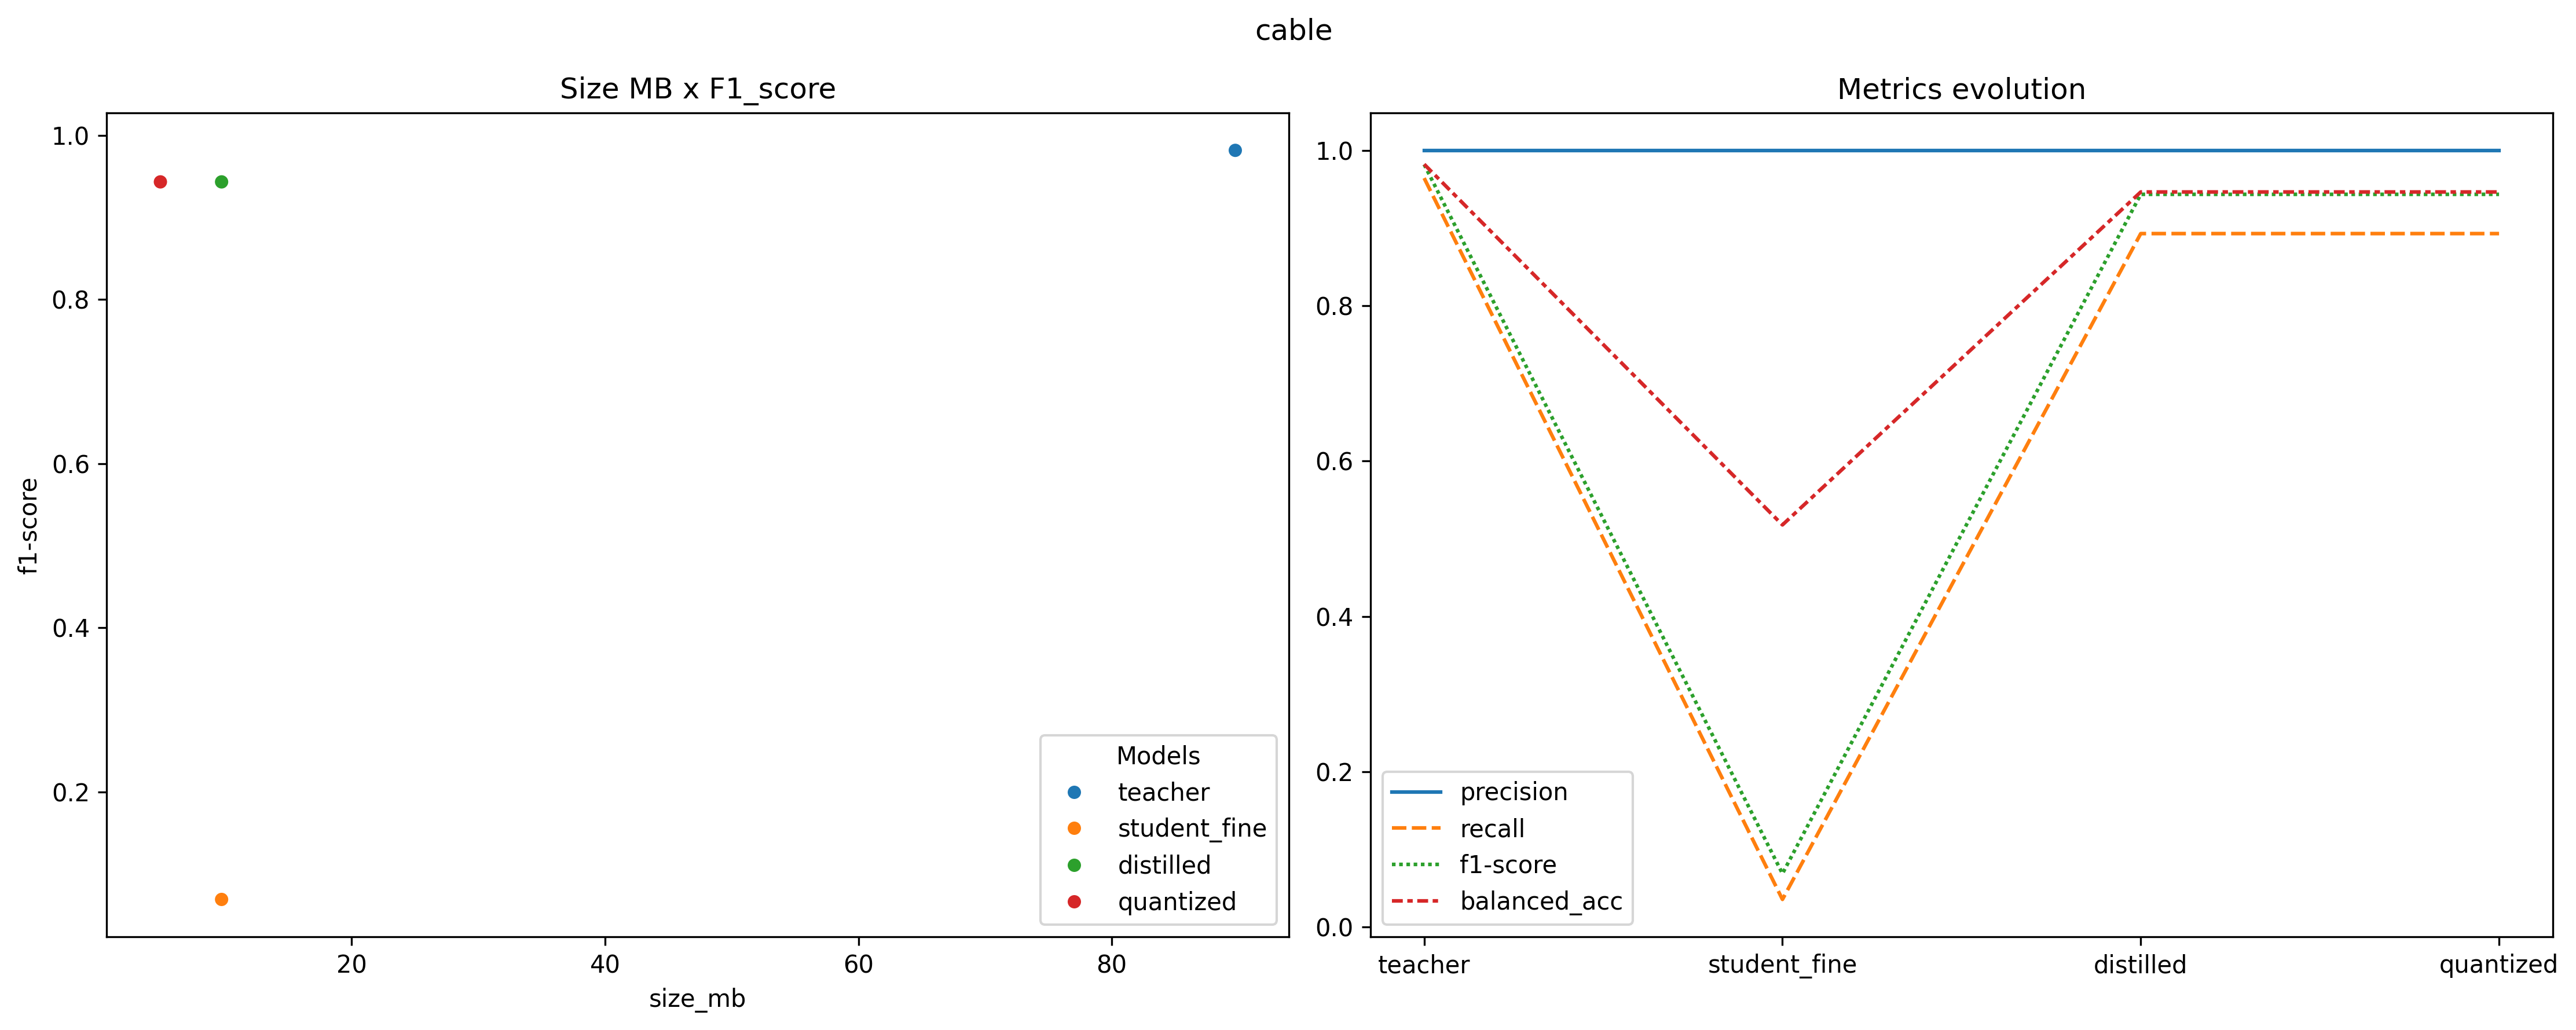

In [40]:
# PLOT THE METRICS TO THE obj
with open(metrics_file_path, 'r', encoding='utf-8') as f:
    objects_metrics = json.load(f)
evaluate.plot_metrics(objects_metrics[obj], obj)